## Loading in Modules for the Spatial and Monthly Correlation

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj

#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from matplotlib.path import Path

# plotting libraries
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob
import array

## Loading Functions Required for the Analysis

In [2]:
def iceshelf_gridsize(dictionary,type_of_analysis):
    
    gridsize_shelves = {}
    
    for key in dictionary:    
        if type_of_analysis == 'seasonal':
            shelf_gridsize = seasonal_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
    
        elif type_of_analysis == 'yearly':
            shelf_gridsize = yearly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
                
    return gridsize_shelves

In [3]:
def shelf_weights(dictionary,type_of_analysis,keys):

    gridsize_shelves = iceshelf_gridsize(dictionary,type_of_analysis)

    gridsize_for_group = {}
    
    total_shelf_weights = {}
    
    for key in keys:
        gridsize_for_group[key] = gridsize_shelves[key]  
    
    for key in gridsize_for_group: 
        total_shelf_weights[key] = gridsize_for_group[key]/sum(gridsize_for_group.values())

    return total_shelf_weights

In [4]:
def spatial_correlation(shelf_name,type_of_analysis):

    if type_of_analysis == 'yearly':
        shelf = yearly_shelves[shelf_name]
        shelf_reanalysis = yearly_reanalysis[shelf_name]
        data_for_indicies_of_array_to_fill = yearly_shelves[shelf_name]['year'][0]
     
        shelf_reanalysis_temp = np.array(shelf_reanalysis['cropped temp'][0])
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1

        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

        for i in range(len(shelf['year'])):
            data_for_indicies = yearly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1# Added to correct the time to make the models range from 1940-2022
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
          
        model_names = list(shelf['Model'])
        models_mean = np.mean(shelf_cropped_temp,axis=0)
        models_mean_spatial_avg = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')


        shelf_cropped_temp_spatial_avg[-1]= models_mean_spatial_avg
        shelf_cropped_temp[-1] = models_mean
        
        shelf_reanalysis_year = shelf_reanalysis['year'][0]
        
        reanalysis_reshaped = shelf_reanalysis_temp
        
        nmod = len(model_names)
        columns = len(reanalysis_reshaped[0])

        model_spatial_corr = np.zeros(nmod)

        for i in range(nmod):
            pearson = []
            for k in range(columns):
                modelname = model_names[i]
                model = shelf_cropped_temp[i]
                #print(model)
                test_x = model[:,k]
                test_y = reanalysis_reshaped[:,k]
                pearson_val = np.corrcoef(test_x,test_y)[0][1]
                pearson.append(pearson_val)
            pearson_avg = np.mean(pearson)
            model_spatial_corr[i] = pearson_avg
        
    elif type_of_analysis == 'seasonal':
        shelf = seasonal_shelves[shelf_name]
        shelf_reanalysis = seasonal_reanalysis[shelf_name]
        data_for_indicies_of_array_to_fill = seasonal_shelves[shelf_name]['year'][0]
        
        shelf_reanalysis_temp = np.array(shelf_reanalysis['cropped temp'][0])
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]
        
        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1# Added to correct the time to make the models range from 1940-2022

        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

        for i in range(len(shelf['year'])):
            data_for_indicies = seasonal_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
        
        model_names = list(shelf['Model'])
        models_mean = np.mean(shelf_cropped_temp,axis=0)
        models_mean_spatial_avg = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')

        shelf_cropped_temp_spatial_avg[-1]= models_mean_spatial_avg
        shelf_cropped_temp[-1] = models_mean
        
        
        #Dropping Last season which is only made up of 1 month
        shelf_reanalysis_temp = shelf_reanalysis_temp[:-1]
        shelf_reanalysis_year = shelf_reanalysis['year'][0][:-1]
        
        reanalysis_reshaped = shelf_reanalysis_temp
        
        nmod = len(model_names)
        columns = len(reanalysis_reshaped[0])

        model_spatial_corr = np.zeros(nmod)

        for i in range(nmod):
            pearson = []
            for k in range(columns):
                modelname = model_names[i]
                model = shelf_cropped_temp[i]
                #print(model)
                test_x = model[:,k]
                test_y = reanalysis_reshaped[:,k]
                pearson_val = np.corrcoef(test_x,test_y)[0][1]
                pearson.append(pearson_val)
            pearson_avg = np.mean(pearson)
            model_spatial_corr[i] = pearson_avg
            
    elif type_of_analysis == 'monthly':
        shelf = monthly_shelves[shelf_name]
        shelf_reanalysis = monthly_reanalysis[shelf_name]
        data_for_indicies_of_array_to_fill = monthly_shelves[shelf_name]['year'][0]
     
        shelf_reanalysis_temp = np.array(shelf_reanalysis['cropped temp'][0])
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1

        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

        for i in range(len(shelf['year'])):
            data_for_indicies = monthly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1# Added to correct the time to make the models range from 1940-2022
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
          
        model_names = list(shelf['Model'])
        models_mean = np.mean(shelf_cropped_temp,axis=0)
        models_mean_spatial_avg = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')


        shelf_cropped_temp_spatial_avg[-1]= models_mean_spatial_avg
        shelf_cropped_temp[-1] = models_mean
        
        shelf_reanalysis_year = shelf_reanalysis['year'][0]
        
        reanalysis_reshaped = shelf_reanalysis_temp
        
        nmod = len(model_names)
        columns = len(reanalysis_reshaped[0])

        model_spatial_corr = np.zeros(nmod+1)

        for i in range(nmod):
            pearson = []
            for k in range(columns):
                modelname = model_names[i]
                model = shelf_cropped_temp[i]
                #print(model)
                test_x = model[:,k]
                test_y = reanalysis_reshaped[:,k]
                pearson_val = np.corrcoef(test_x,test_y)[0][1]
                pearson.append(pearson_val)
            pearson_avg = np.mean(pearson)
            model_spatial_corr[i] = pearson_avg
        
        model_names.append('ERA5')
        model_spatial_corr[-1] = 1.000
        

        
    df = pd.DataFrame(list(zip(model_names,model_spatial_corr,)),columns=['Model Names','Pearson Corr'])
    
    
    return df

In [5]:
elif type_of_analysis == 'monthly':
        shelf = monthly_shelves[shelf_name]
        shelf_reanalysis = monthly_reanalysis[shelf_name]
        data_for_indicies_of_array_to_fill = monthly_shelves[shelf_name]['year'][0]
     
        shelf_reanalysis_temp = np.array(shelf_reanalysis['cropped temp'][0])
        y1 = shelf_reanalysis['year'][0][0]
        y2 = shelf_reanalysis['year'][0][-1]

        index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
        index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1

        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
        shelf_cropped_temp = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

        for i in range(len(shelf['year'])):
            data_for_indicies = monthly_shelves[shelf_name]['year'][i]

            index1 = np.where(data_for_indicies == y1)[0][0]
            index2 = np.where(data_for_indicies == y2)[0][-1]+1# Added to correct the time to make the models range from 1940-2022
            
            shelf_cropped[i] = shelf['year'][i][index1:index2]
            shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]
          
        model_names = list(shelf['Model'])
        models_mean = np.mean(shelf_cropped_temp,axis=0)
        models_mean_spatial_avg = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')


        shelf_cropped_temp_spatial_avg[-1]= models_mean_spatial_avg
        shelf_cropped_temp[-1] = models_mean
        
        shelf_reanalysis_year = shelf_reanalysis['year'][0]
        
        reanalysis_reshaped = shelf_reanalysis_temp
        
        nmod = len(model_names)
        columns = len(reanalysis_reshaped[0])

        model_spatial_corr = np.zeros(nmod)

        for i in range(nmod):
            pearson = []
            for k in range(columns):
                modelname = model_names[i]
                model = shelf_cropped_temp[i]
                #print(model)
                test_x = model[:,k]
                test_y = reanalysis_reshaped[:,k]
                pearson_val = np.corrcoef(test_x,test_y)[0][1]
                pearson.append(pearson_val)
            pearson_avg = np.mean(pearson)
            model_spatial_corr[i] = pearson_avg

SyntaxError: invalid syntax (3286586475.py, line 1)

In [6]:
def total_shelf_weights(dictionary,type_of_analysis):
    
    gridsize_shelves = iceshelf_gridsize(dictionary,type_of_analysis)

    total_shelf_weights = {}

    for key in gridsize_shelves: 
        total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())
        
    return total_shelf_weights

In [7]:
def grouping_analysis_selection_spatial_corr(dictionary,weights,key):
    
    applied_weights = {}
    
    for key in keys:
        weighted_bias = dictionary[key]['Pearson Corr'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights

In [8]:
def bias_analysis_shelf_alphabet(dictionary):
    
    new_dictionary = {}
    
    for key in dictionary:
        new_dictionary[key] = dictionary[key].sort_values('Model Names')
    
    return new_dictionary

In [9]:
def iceshelf_dictionary_spatial_corr(dictionary,type_of_analysis):

    for key in dictionary:    
        df_shelf = spatial_correlation(key,type_of_analysis)
        if type_of_analysis == 'seasonal':
            spatial_correlation_seasonal[key] = df_shelf
            print(key)
        elif type_of_analysis == 'yearly':
            spatial_correlation_yearly[key] = df_shelf
            print(key)
            
        elif type_of_analysis == 'monthly':
            spatial_correlation_monthly[key] = df_shelf
            print(key)
            
    task = 'completed task'
                
    return task

In [10]:
def rmse(predictions, targets):
    predictions_mean = np.mean(predictions)
    targets_mean = np.mean(targets)
    C_RMSE = np.sqrt(np.mean(((predictions-predictions_mean)-(targets-targets_mean))**2))
    RMS = np.sqrt(np.mean((predictions-targets)**2))
    
    return C_RMSE, RMS

In [11]:
def monthly_correlation(shelf_name):

    shelf = monthly_shelves[shelf_name]
    shelf_reanalysis = monthly_reanalysis[shelf_name]
    data_for_indicies_of_array_to_fill = monthly_shelves[shelf_name]['year'][0]

    shelf_reanalysis_temp = np.array(shelf_reanalysis['cropped temp'][0])
    y1 = shelf_reanalysis['year'][0][0]
    y2 = shelf_reanalysis['year'][0][-1]

    index1_fill = np.where(data_for_indicies_of_array_to_fill == y1)[0][0]
    index2_fill = np.where(data_for_indicies_of_array_to_fill == y2)[0][-1]+1

    shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][index1_fill:index2_fill])))
    shelf_cropped_temp = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill]),len(shelf['cropped lon'][0])))
    shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][index1_fill:index2_fill])))

    for i in range(len(shelf['year'])):
        data_for_indicies = monthly_shelves[shelf_name]['year'][i]

        index1 = np.where(data_for_indicies == y1)[0][0]
        index2 = np.where(data_for_indicies == y2)[0][-1]+1# Added to correct the time to make the models range from 1940-2022

        shelf_cropped[i] = shelf['year'][i][index1:index2]
        shelf_cropped_temp[i] = shelf['cropped temp'][i][index1:index2]
        shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][index1:index2]

    model_names = list(shelf['Model'])
    models_mean = np.mean(shelf_cropped_temp,axis=0)
    models_mean_spatial_avg = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
    model_names.append('Model Mean')


    shelf_cropped_temp_spatial_avg[-1]= models_mean_spatial_avg
    shelf_cropped_temp[-1] = models_mean

    shelf_reanalysis_year = shelf_reanalysis['year'][0]

    reanalysis_spatial_avg = np.mean(shelf_reanalysis_temp,axis=1)
    
    nmod = len(model_names)

    model_monthly_corr = np.zeros(nmod+1)
    std = np.zeros(nmod+1)
    RMSE = np.zeros(nmod+1)
    CRMSE = np.zeros(nmod+1)

    for i in range(nmod):
        
        modelname = model_names[i]
        model = shelf_cropped_temp_spatial_avg[i]
        
        std[i] = np.std(model)
        RMSE[i] = rmse(model,reanalysis_spatial_avg)[1]
        CRMSE[i] = rmse(model,reanalysis_spatial_avg)[0]
        pearson_val = np.corrcoef(model,reanalysis_spatial_avg)[0][1]
        model_monthly_corr[i] = pearson_val
    
    model_names.append('ERA5')
    model_monthly_corr[-1] = np.corrcoef(reanalysis_spatial_avg,reanalysis_spatial_avg)[0][1]
    std[-1] = np.std(reanalysis_spatial_avg)
    RMSE[-1] = rmse(reanalysis_spatial_avg,reanalysis_spatial_avg)[1]
    CRMSE[-1] = rmse(reanalysis_spatial_avg,reanalysis_spatial_avg)[0]

    df = pd.DataFrame(list(zip(model_names,model_monthly_corr,std,RMSE,CRMSE)),columns=['Model Names','Pearson Corr','Standard Deviation','RMSE','Centered RMSE'])

    
    return df

In [12]:
def iceshelf_dictionary_monthly_corr(dictionary):
    new_dictionary = {}
    for key in dictionary:    
        df_shelf = monthly_correlation(key)
        new_dictionary[key] = df_shelf
                
    return new_dictionary

In [13]:
def shelf_weights(dictionary,type_of_analysis,keys):

    gridsize_shelves = iceshelf_gridsize(dictionary,type_of_analysis)

    gridsize_for_group = {}
    
    total_shelf_weights = {}
    
    for key in keys:
        gridsize_for_group[key] = gridsize_shelves[key]  
    
    for key in gridsize_for_group: 
        total_shelf_weights[key] = gridsize_for_group[key]/sum(gridsize_for_group.values())

    return total_shelf_weights

In [14]:
def iceshelf_gridsize(dictionary,type_of_analysis):
    
    gridsize_shelves = {}
    
    for key in dictionary:    
        if type_of_analysis == 'seasonal':
            shelf_gridsize = seasonal_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
    
        elif type_of_analysis == 'yearly':
            shelf_gridsize = yearly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
        
        elif type_of_analysis == 'monthly':
            shelf_gridsize = monthly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
                
    return gridsize_shelves

In [25]:
##Weights for All Shelves

gridsize_shelves = iceshelf_gridsize(monthly_shelves,'monthly')

total_shelf_weights = {}

for key in gridsize_shelves: 
    total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())

print(total_shelf_weights)

{'Abbot': 0.014959723820483314, 'Amery': 0.024793388429752067, 'Atka': 0.000941521079610838, 'Baudouin': 0.012972068207971544, 'Borchgrevink': 0.00878753007636782, 'Brunt Stancomb': 0.01945810231195732, 'Conger Glenzer': 0.0004184538131603724, 'Cook': 0.0012553614394811173, 'Cosgrove': 0.0011507479861910242, 'Crosson': 0.0015692017993513966, 'Dotson': 0.003138403598702793, 'Drygalski': 0.0008369076263207448, 'Ekstrom': 0.0025107228789622345, 'Filchner': 0.08525996443142587, 'George VI': 0.01046134532900931, 'Getz': 0.01715660633957527, 'Holmes': 0.0008369076263207448, 'Jelbart': 0.00439376503818391, 'Land': 0.0003138403598702793, 'LarsenB': 0.0006276807197405586, 'LarsenC': 0.01642431216654462, 'LarsenD': 0.010147504969139031, 'Lazarev': 0.0036614708651532585, 'Mariner': 0.0014645883460613035, 'Mertz': 0.001987655612511769, 'Moscow University': 0.0015692017993513966, 'Nansen': 0.000941521079610838, 'Nickerson': 0.004079924678313631, 'Nivl': 0.0028245632388325136, 'pine island': 0.00355

In [16]:
def grouping_bias_analysis(dictionary,weights,keys):
    
    applied_weights = {}
    
    for key in keys:
        weighted_bias = dictionary[key]['Coefficient of Variation'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights

In [17]:
def bias_analysis_shelf_alphabet(dictionary):
    
    new_dictionary = {}
    
    for key in dictionary:
        new_dictionary[key] = dictionary[key].sort_values('Model Names')
    
    return new_dictionary

In [18]:
def grouping_analysis_selection_std(dictionary,weights,key):
    
    applied_weights = {}
    
    for key in keys:
        weighted_PC = dictionary[key]['Pearson Corr'] * weights[key]
        weighted_std = dictionary[key]['Standard Deviation'] * weights[key]
        weighted_RMSE = dictionary[key]['RMSE'] * weights[key]
        weighted_CRMSE = dictionary[key]['Centered RMSE'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_PC,weighted_std,weighted_RMSE,weighted_CRMSE], axis=1)
        applied_weights[key] = df
        
    return applied_weights

## Reading in Pre-Made Data Frames

In [19]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/monthly_shelves.pkl', 'rb') as f:
    monthly_shelves = pickle.load(f)

In [20]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/seasonal_shelves.pkl', 'rb') as f:
    seasonal_shelves = pickle.load(f)

In [21]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/yearly_shelves.pkl', 'rb') as f:
    yearly_shelves = pickle.load(f)

In [22]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_monthly.pkl', 'rb') as f:
    monthly_reanalysis = pickle.load(f)

In [23]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_seasonal.pkl', 'rb') as f:
    seasonal_reanalysis = pickle.load(f)

In [24]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_yearly.pkl', 'rb') as f:
    yearly_reanalysis = pickle.load(f)

### Creating Weights for Study Regions

1) Ross Ice Shelf: includes Ross East and Ross West 
2) Ronne-Filcner: includes Ronne and Filchner 
3) Larsen: includes Larsen B,C, and D
4) Amundsen Sea Embayment (ASE): includes 'Getz','Dotson','Crosson','Thwaites','pine island','Cosgrove', 'Abbot', 'Venable'

In [26]:
#Weights for Analysis of the Ross Iceshelf

keys = list(('Ross East','Ross West'))

weights_Ross = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ross)

{'Ross East': 0.37747554282987356, 'Ross West': 0.6225244571701265}


In [27]:
#Weights for Analysis of the Ronne-Filchner

keys = list(('Ronne','Filchner'))

weights_Ronne_Filchner = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Ronne_Filchner)

{'Ronne': 0.7420069642291864, 'Filchner': 0.25799303577081356}


In [28]:
#Weights for Analysis of the Larsen Iceshelf

keys = list(('LarsenB','LarsenC','LarsenD'))

weights_Larsen = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_Larsen)

{'LarsenB': 0.023076923076923078, 'LarsenC': 0.6038461538461538, 'LarsenD': 0.3730769230769231}


In [29]:
#Weights for Analysis of Amundsen Sea Embayment

keys = list(('Dotson','Crosson','Thwaites','pine island'))

weights_ASE = shelf_weights(yearly_shelves,'yearly',keys)

print(weights_ASE)

{'Dotson': 0.28846153846153844, 'Crosson': 0.14423076923076922, 'Thwaites': 0.2403846153846154, 'pine island': 0.3269230769230769}


In [30]:
##Weights for All Shelves

gridsize_shelves = iceshelf_gridsize(yearly_shelves,'yearly')

total_shelf_weights = {}

for key in gridsize_shelves: 
    total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())

print(total_shelf_weights)

{'Abbot': 0.015256588072122053, 'Amery': 0.025285394217433053, 'Atka': 0.0009602048436999893, 'Baudouin': 0.013229488957644298, 'Borchgrevink': 0.008961911874533234, 'Conger Glenzer': 0.0004267577083111064, 'Cook': 0.001280273124933319, 'Cosgrove': 0.0011735836978555424, 'Crosson': 0.0016003414061666488, 'Dotson': 0.0032006828123332977, 'Drygalski': 0.0008535154166222128, 'Ekstrom': 0.002560546249866638, 'Filchner': 0.08695188306838793, 'George VI': 0.01066894270777766, 'Getz': 0.01749706604075536, 'Holmes': 0.0008535154166222128, 'Jelbart': 0.004480955937266617, 'Land': 0.00032006828123332977, 'LarsenB': 0.0006401365624666595, 'LarsenC': 0.016750240051210924, 'LarsenD': 0.010348874426544329, 'Lazarev': 0.0037341299477221808, 'Mariner': 0.0014936519790888724, 'Mertz': 0.002027099114477755, 'Moscow University': 0.0016003414061666488, 'Nansen': 0.0009602048436999893, 'Nickerson': 0.004160887656033287, 'Nivl': 0.002880614531099968, 'pine island': 0.0036274405206444043, 'Prince Harald': 0.

### Spatial Analysis

In [31]:
spatial_correlation_seasonal = {}
spatial_correlation_yearly = {}

In [32]:
spatial_correlation_monthly = {}

In [33]:
iceshelf_dictionary_spatial_corr(yearly_shelves,'yearly')
iceshelf_dictionary_spatial_corr(seasonal_shelves,'seasonal')

Abbot
Amery
Atka
Baudouin
Borchgrevink
Conger Glenzer
Cook
Cosgrove
Crosson
Dotson
Drygalski
Ekstrom
Filchner
George VI
Getz
Holmes
Jelbart
Land
LarsenB
LarsenC
LarsenD
Lazarev
Mariner
Mertz
Moscow University
Nansen
Nickerson
Nivl
pine island
Prince Harald
Quar
Rennick
Riiser-Larsen
Ronne
Ross East
Ross West
Shackleton
Stange
Sulzberger
Thwaites
Totten
Venable
Vigrid
West
Withrow
Abbot
Amery
Atka
Baudouin
Borchgrevink
Conger Glenzer
Cook
Cosgrove
Crosson
Dotson
Drygalski
Ekstrom
Filchner
George VI
Getz
Holmes
Jelbart
Land
LarsenB
LarsenC
LarsenD
Lazarev
Mariner
Mertz
Moscow University
Nansen
Nickerson
Nivl
pine island
Prince Harald
Quar
Rennick
Riiser-Larsen
Ronne
Ross East
Ross West
Shackleton
Stange
Sulzberger
Thwaites
Totten
Venable
Vigrid
West
Withrow


'completed task'

In [34]:
iceshelf_dictionary_spatial_corr(monthly_shelves,'monthly')

Abbot
Amery
Atka
Baudouin
Borchgrevink
Brunt Stancomb
Conger Glenzer
Cook
Cosgrove
Crosson
Dotson
Drygalski
Ekstrom
Filchner
George VI
Getz
Holmes
Jelbart
Land
LarsenB
LarsenC
LarsenD
Lazarev
Mariner
Mertz
Moscow University
Nansen
Nickerson
Nivl
pine island
Prince Harald
Quar
Rennick
Riiser-Larsen
Ronne
Ross East
Ross West
Shackleton
Stange
Sulzberger
Thwaites
Totten
Venable
Vigrid
West
Withrow


'completed task'

In [35]:
spatial_correlation_yearly_alphabet = bias_analysis_shelf_alphabet(spatial_correlation_yearly)
spatial_correlation_yearly_alphabet

{'Abbot':          Model Names  Pearson Corr
 20        ACCESS-CM2     -0.066725
 18     ACCESS-ESM1-5      0.291721
 9      AWI-CM-1-1-MR      0.067402
 4        CAMS-CSM1-0     -0.023974
 1         CAS-ESM2-0      0.145773
 28       CESM2-WACCM      0.132984
 11      CMCC-CM2-SR5      0.314197
 12         CMCC-ESM2      0.244540
 26           CanESM5      0.035345
 0           E3SM-1-1     -0.179172
 29      E3SM-1-1-ECA      0.241026
 3       E3SM-Project     -0.018397
 14         EC-Earth3      0.139806
 22     EC-Earth3-Veg      0.054006
 23  EC-Earth3-Veg-LR      0.276539
 8        FGOALS-f3-L      0.250231
 17         FGOALS-g3      0.129982
 21         GFDL-ESM4      0.180459
 15          IITM-ESM      0.313156
 6          INM-CM4-8      0.141580
 7          INM-CM5-0      0.054599
 13      IPSL-CM6A-LR      0.040075
 2          KIOST-ESM      0.131880
 27            MIROC6      0.002869
 5      MPI-ESM1-2-HR      0.185796
 30     MPI-ESM1-2-LR      0.255871
 25        MRI-ESM2

In [36]:
spatial_correlation_monthly_alphabet = bias_analysis_shelf_alphabet(spatial_correlation_monthly)
spatial_correlation_monthly_alphabet

{'Abbot':          Model Names  Pearson Corr
 20        ACCESS-CM2      0.794783
 18     ACCESS-ESM1-5      0.741441
 9      AWI-CM-1-1-MR      0.763237
 4        CAMS-CSM1-0      0.747917
 1         CAS-ESM2-0      0.788193
 28       CESM2-WACCM     -0.398437
 11      CMCC-CM2-SR5      0.714673
 12         CMCC-ESM2      0.702555
 26           CanESM5      0.665623
 0           E3SM-1-1      0.730395
 29      E3SM-1-1-ECA      0.738730
 3       E3SM-Project      0.734113
 14         EC-Earth3      0.728815
 22     EC-Earth3-Veg      0.719326
 23  EC-Earth3-Veg-LR      0.735967
 32              ERA5      1.000000
 8        FGOALS-f3-L     -0.210886
 17         FGOALS-g3      0.728728
 21         GFDL-ESM4      0.718540
 15          IITM-ESM      0.768335
 6          INM-CM4-8      0.655024
 7          INM-CM5-0      0.650054
 13      IPSL-CM6A-LR      0.786123
 2          KIOST-ESM      0.651347
 27            MIROC6      0.738330
 5      MPI-ESM1-2-HR      0.731900
 30     MPI-ESM1-2-

In [37]:
keys = list(('Ross East','Ross West'))
ross_applied_weights_yearly = grouping_analysis_selection_spatial_corr(spatial_correlation_yearly_alphabet,weights_Ross,keys)
ross_spatial_correlation_yearly = ross_applied_weights_yearly['Ross East']['Pearson Corr'] + ross_applied_weights_yearly['Ross West']['Pearson Corr']

ross_model_names = ross_applied_weights_yearly['Ross East']['Model Names']

ross_spatial_correlation_data_yearly = pd.DataFrame(list(zip(ross_model_names,ross_spatial_correlation_yearly)),columns=['Model Names','Pearson Corr'])
ross_spatial_correlation_data_yearly

,Model Names,Pearson Corr
0,ACCESS-CM2,-0.035233
1,ACCESS-ESM1-5,0.327132
2,AWI-CM-1-1-MR,0.143467
3,CAMS-CSM1-0,0.183116
4,CAS-ESM2-0,0.100114
5,CESM2-WACCM,0.251181
6,CMCC-CM2-SR5,0.321924
7,CMCC-ESM2,0.219954
8,CanESM5,0.270152
9,E3SM-1-1,0.011437


In [38]:
keys = list(('Ronne','Filchner'))

ronne_applied_weights_yearly = grouping_analysis_selection_spatial_corr(spatial_correlation_yearly_alphabet,weights_Ronne_Filchner,keys)
ronne_spatial_correlation_yearly = ronne_applied_weights_yearly['Ronne']['Pearson Corr'] + ronne_applied_weights_yearly['Filchner']['Pearson Corr']

ronne_model_names = ronne_applied_weights_yearly['Ronne']['Model Names']

ronne_spatial_correlation_data_yearly = pd.DataFrame(list(zip(ronne_model_names,ronne_spatial_correlation_yearly)),columns=['Model Names','Pearson Corr'])
ronne_spatial_correlation_data_yearly

,Model Names,Pearson Corr
0,ACCESS-CM2,0.283134
1,ACCESS-ESM1-5,0.237610
2,AWI-CM-1-1-MR,0.311193
3,CAMS-CSM1-0,0.240402
4,CAS-ESM2-0,0.248219
5,CESM2-WACCM,0.316065
6,CMCC-CM2-SR5,0.317743
7,CMCC-ESM2,0.241818
8,CanESM5,0.246974
9,E3SM-1-1,0.091118


In [39]:
keys = list(('LarsenB','LarsenC','LarsenD'))

larsen_applied_weights_yearly = grouping_analysis_selection_spatial_corr(spatial_correlation_yearly_alphabet,weights_Larsen,keys)
larsen_spatial_correlation_yearly = larsen_applied_weights_yearly['LarsenB']['Pearson Corr'] + larsen_applied_weights_yearly['LarsenC']['Pearson Corr']+larsen_applied_weights_yearly['LarsenD']['Pearson Corr']

larsen_model_names = larsen_applied_weights_yearly['LarsenB']['Model Names']

larsen_spatial_correlation_data_yearly = pd.DataFrame(list(zip(larsen_model_names,larsen_spatial_correlation_yearly)),columns=['Model Names','Pearson Corr'])
larsen_spatial_correlation_data_yearly

,Model Names,Pearson Corr
0,ACCESS-CM2,0.175170
1,ACCESS-ESM1-5,0.202002
2,AWI-CM-1-1-MR,0.394780
3,CAMS-CSM1-0,0.111297
4,CAS-ESM2-0,0.109556
5,CESM2-WACCM,0.365504
6,CMCC-CM2-SR5,0.363414
7,CMCC-ESM2,0.314643
8,CanESM5,0.056776
9,E3SM-1-1,0.104958


In [40]:
keys = list(('Dotson','Crosson','Thwaites','pine island'))

ASE_applied_weights_yearly = grouping_analysis_selection_spatial_corr(spatial_correlation_yearly_alphabet,weights_ASE,keys)
ASE_spatial_correlation_yearly = ASE_applied_weights_yearly['Dotson']['Pearson Corr'] + ASE_applied_weights_yearly['Crosson']['Pearson Corr']+ASE_applied_weights_yearly['Thwaites']['Pearson Corr']+ASE_applied_weights_yearly['pine island']['Pearson Corr']

ASE_model_names = ASE_applied_weights_yearly['Dotson']['Model Names']

ASE_spatial_correlation_data_yearly = pd.DataFrame(list(zip(ASE_model_names,ASE_spatial_correlation_yearly)),columns=['Model Names','Pearson Corr'])
ASE_spatial_correlation_data_yearly

,Model Names,Pearson Corr
0,ACCESS-CM2,-0.018391
1,ACCESS-ESM1-5,0.289755
2,AWI-CM-1-1-MR,0.029595
3,CAMS-CSM1-0,0.024923
4,CAS-ESM2-0,0.089946
5,CESM2-WACCM,0.100583
6,CMCC-CM2-SR5,0.334294
7,CMCC-ESM2,0.312655
8,CanESM5,0.061461
9,E3SM-1-1,-0.154117


In [41]:
keys = total_shelf_weights.keys()

total_shelf_applied_weights_monthly = grouping_analysis_selection_spatial_corr(spatial_correlation_monthly_alphabet,total_shelf_weights,keys)


total_shelf_spatial_correlation_monthly = np.zeros(len(total_shelf_applied_weights_monthly['Ross East']))

for key in total_shelf_applied_weights_monthly: 
    total_shelf_spatial_correlation_monthly += total_shelf_applied_weights_monthly[key]['Pearson Corr']

model_names = total_shelf_applied_weights_monthly['Ross East']['Model Names']

total_shelf_spatial_correlation_data_monthly = pd.DataFrame(list(zip(model_names,total_shelf_spatial_correlation_monthly)),columns=['Model Names','Pearson Corr'])
total_shelf_spatial_correlation_data_monthly

,Model Names,Pearson Corr
0,ACCESS-CM2,0.904745
1,ACCESS-ESM1-5,0.887820
2,AWI-CM-1-1-MR,0.873694
3,CAMS-CSM1-0,0.774346
4,CAS-ESM2-0,0.789094
5,CESM2-WACCM,-0.412090
6,CMCC-CM2-SR5,0.778567
7,CMCC-ESM2,0.773435
8,CanESM5,0.732878
9,E3SM-1-1,0.798369


## Seasonal Spatial Analysis

In [42]:
spatial_correlation_seasonal_alphabet = bias_analysis_shelf_alphabet(spatial_correlation_seasonal)
spatial_correlation_seasonal_alphabet

{'Abbot':          Model Names  Pearson Corr
 20        ACCESS-CM2     -0.062276
 18     ACCESS-ESM1-5     -0.031102
 9      AWI-CM-1-1-MR      0.216350
 4        CAMS-CSM1-0      0.044940
 1         CAS-ESM2-0     -0.108131
 28       CESM2-WACCM      0.023192
 11      CMCC-CM2-SR5      0.033829
 12         CMCC-ESM2     -0.011224
 26           CanESM5     -0.039001
 0           E3SM-1-1     -0.135377
 29      E3SM-1-1-ECA     -0.028151
 3       E3SM-Project      0.052867
 14         EC-Earth3     -0.017690
 22     EC-Earth3-Veg     -0.008090
 23  EC-Earth3-Veg-LR     -0.093215
 8        FGOALS-f3-L      0.156434
 17         FGOALS-g3     -0.046257
 21         GFDL-ESM4      0.065458
 15          IITM-ESM      0.019324
 6          INM-CM4-8      0.058608
 7          INM-CM5-0     -0.026033
 13      IPSL-CM6A-LR     -0.040203
 2          KIOST-ESM      0.069335
 27            MIROC6     -0.030547
 5      MPI-ESM1-2-HR      0.010498
 30     MPI-ESM1-2-LR      0.096127
 25        MRI-ESM2

In [43]:
keys = list(('Ross East','Ross West'))
ross_applied_weights_seasonal = grouping_analysis_selection_spatial_corr(spatial_correlation_seasonal_alphabet,weights_Ross,keys)
ross_spatial_correlation_seasonal = ross_applied_weights_seasonal['Ross East']['Pearson Corr'] + ross_applied_weights_seasonal['Ross West']['Pearson Corr']

ross_model_names = ross_applied_weights_seasonal['Ross East']['Model Names']

ross_spatial_correlation_data_seasonal = pd.DataFrame(list(zip(ross_model_names,ross_spatial_correlation_seasonal)),columns=['Model Names','Pearson Corr'])
ross_spatial_correlation_data_seasonal

,Model Names,Pearson Corr
0,ACCESS-CM2,0.113578
1,ACCESS-ESM1-5,0.253606
2,AWI-CM-1-1-MR,0.102221
3,CAMS-CSM1-0,0.035517
4,CAS-ESM2-0,0.049234
5,CESM2-WACCM,0.211303
6,CMCC-CM2-SR5,0.167522
7,CMCC-ESM2,0.228554
8,CanESM5,0.191345
9,E3SM-1-1,0.197232


In [44]:
keys = list(('Ronne','Filchner'))

ronne_applied_weights_seasonal = grouping_analysis_selection_spatial_corr(spatial_correlation_seasonal_alphabet,weights_Ronne_Filchner,keys)
ronne_spatial_correlation_seasonal = ronne_applied_weights_seasonal['Ronne']['Pearson Corr'] + ronne_applied_weights_seasonal['Filchner']['Pearson Corr']

ronne_model_names = ronne_applied_weights_seasonal['Ronne']['Model Names']

ronne_spatial_correlation_data_seasonal = pd.DataFrame(list(zip(ronne_model_names,ronne_spatial_correlation_seasonal)),columns=['Model Names','Pearson Corr'])
ronne_spatial_correlation_data_seasonal

,Model Names,Pearson Corr
0,ACCESS-CM2,0.091913
1,ACCESS-ESM1-5,0.103904
2,AWI-CM-1-1-MR,0.318486
3,CAMS-CSM1-0,0.148728
4,CAS-ESM2-0,0.240763
5,CESM2-WACCM,0.278072
6,CMCC-CM2-SR5,0.195057
7,CMCC-ESM2,0.213760
8,CanESM5,0.097165
9,E3SM-1-1,0.254461


In [45]:
keys = list(('LarsenB','LarsenC','LarsenD'))

larsen_applied_weights_seasonal = grouping_analysis_selection_spatial_corr(spatial_correlation_seasonal_alphabet,weights_Larsen,keys)
larsen_spatial_correlation_seasonal = larsen_applied_weights_seasonal['LarsenB']['Pearson Corr'] + larsen_applied_weights_seasonal['LarsenC']['Pearson Corr']+larsen_applied_weights_seasonal['LarsenD']['Pearson Corr']

larsen_model_names = larsen_applied_weights_seasonal['LarsenB']['Model Names']

larsen_spatial_correlation_data_seasonal = pd.DataFrame(list(zip(larsen_model_names,larsen_spatial_correlation_seasonal)),columns=['Model Names','Pearson Corr'])
larsen_spatial_correlation_data_seasonal

,Model Names,Pearson Corr
0,ACCESS-CM2,0.168467
1,ACCESS-ESM1-5,0.157614
2,AWI-CM-1-1-MR,0.158443
3,CAMS-CSM1-0,0.185285
4,CAS-ESM2-0,0.012404
5,CESM2-WACCM,0.099511
6,CMCC-CM2-SR5,0.157990
7,CMCC-ESM2,0.083080
8,CanESM5,0.139442
9,E3SM-1-1,0.174772


In [46]:
keys = list(('Dotson','Crosson','Thwaites','pine island'))

ASE_applied_weights_seasonal = grouping_analysis_selection_spatial_corr(spatial_correlation_seasonal_alphabet,weights_ASE,keys)
ASE_spatial_correlation_seasonal = ASE_applied_weights_seasonal['Dotson']['Pearson Corr'] + ASE_applied_weights_seasonal['Crosson']['Pearson Corr']+ASE_applied_weights_seasonal['Thwaites']['Pearson Corr']+ASE_applied_weights_seasonal['pine island']['Pearson Corr']

ASE_model_names = ASE_applied_weights_seasonal['Dotson']['Model Names']

ASE_spatial_correlation_data_seasonal = pd.DataFrame(list(zip(ASE_model_names,ASE_spatial_correlation_seasonal)),columns=['Model Names','Pearson Corr'])
ASE_spatial_correlation_data_seasonal

,Model Names,Pearson Corr
0,ACCESS-CM2,0.021048
1,ACCESS-ESM1-5,0.035851
2,AWI-CM-1-1-MR,0.122033
3,CAMS-CSM1-0,0.093155
4,CAS-ESM2-0,-0.106431
5,CESM2-WACCM,0.013062
6,CMCC-CM2-SR5,0.009704
7,CMCC-ESM2,0.049213
8,CanESM5,0.079335
9,E3SM-1-1,-0.019189


In [47]:
keys = spatial_correlation_seasonal_alphabet.keys()

total_shelf_applied_weights_seasonal = grouping_analysis_selection_spatial_corr(spatial_correlation_seasonal_alphabet,total_shelf_weights,keys)


total_shelf_spatial_correlation_seasonal = np.zeros(len(total_shelf_applied_weights_seasonal['Ross East']))

for key in total_shelf_applied_weights_seasonal: 
    total_shelf_spatial_correlation_seasonal += total_shelf_applied_weights_seasonal[key]['Pearson Corr']

model_names = total_shelf_applied_weights_seasonal['Ross East']['Model Names']

total_shelf_spatial_correlation_data_seasonal = pd.DataFrame(list(zip(model_names,total_shelf_spatial_correlation_seasonal)),columns=['Model Names','Pearson Corr'])
total_shelf_spatial_correlation_data_seasonal

,Model Names,Pearson Corr
0,ACCESS-CM2,0.097312
1,ACCESS-ESM1-5,0.170490
2,AWI-CM-1-1-MR,0.183359
3,CAMS-CSM1-0,0.075225
4,CAS-ESM2-0,0.132810
5,CESM2-WACCM,0.221004
6,CMCC-CM2-SR5,0.160495
7,CMCC-ESM2,0.197334
8,CanESM5,0.142505
9,E3SM-1-1,0.188164


## Monthly Correlation



In [48]:
monthly_shelf_correlation = iceshelf_dictionary_monthly_corr(monthly_shelves)
monthly_shelf_correlation = bias_analysis_shelf_alphabet(monthly_shelf_correlation)
monthly_shelf_correlation

{'Abbot':          Model Names  Pearson Corr  Standard Deviation       RMSE  \
 20        ACCESS-CM2      0.805296            8.359546   5.539379   
 18     ACCESS-ESM1-5      0.751851            7.091870   4.848347   
 9      AWI-CM-1-1-MR      0.772238            6.716481   4.756914   
 4        CAMS-CSM1-0      0.756956            8.205948   5.607470   
 1         CAS-ESM2-0      0.796403            7.983788   5.419033   
 28       CESM2-WACCM     -0.401631            9.003775  13.328932   
 11      CMCC-CM2-SR5      0.721812            9.020849   6.994119   
 12         CMCC-ESM2      0.709322            8.762351   6.759152   
 26           CanESM5      0.672719            7.744053   6.801571   
 0           E3SM-1-1      0.738131            7.896980   5.442609   
 29      E3SM-1-1-ECA      0.747107            8.000329   5.377442   
 3       E3SM-Project      0.742435            7.792187   5.348431   
 14         EC-Earth3      0.739724            7.679809   5.872748   
 22     EC-

In [49]:
Amery_shelf_monthly_corr_data = monthly_shelf_correlation['Amery']
Amery_shelf_spatial_correlation_data_monthly = spatial_correlation_monthly_alphabet['Amery']
print(Amery_shelf_spatial_correlation_data_monthly)

         Model Names  Pearson Corr
20        ACCESS-CM2      0.904546
18     ACCESS-ESM1-5      0.880627
9      AWI-CM-1-1-MR      0.902928
4        CAMS-CSM1-0      0.820178
1         CAS-ESM2-0      0.863509
28       CESM2-WACCM     -0.457997
11      CMCC-CM2-SR5      0.786625
12         CMCC-ESM2      0.786729
26           CanESM5      0.725299
0           E3SM-1-1      0.798870
29      E3SM-1-1-ECA      0.808531
3       E3SM-Project      0.804198
14         EC-Earth3      0.888789
22     EC-Earth3-Veg      0.880066
23  EC-Earth3-Veg-LR      0.901552
32              ERA5      1.000000
8        FGOALS-f3-L     -0.327024
17         FGOALS-g3      0.781677
21         GFDL-ESM4      0.773205
15          IITM-ESM      0.910808
6          INM-CM4-8      0.739182
7          INM-CM5-0      0.729844
13      IPSL-CM6A-LR      0.899906
2          KIOST-ESM      0.807439
27            MIROC6      0.904845
5      MPI-ESM1-2-HR      0.881458
30     MPI-ESM1-2-LR      0.868629
25        MRI-ESM2-0

In [50]:
LarsenB_shelf_monthly_corr_data = monthly_shelf_correlation['LarsenB']
LarsenB_shelf_spatial_correlation_data_monthly = spatial_correlation_monthly_alphabet['LarsenB']
print(LarsenB_shelf_spatial_correlation_data_monthly)

         Model Names  Pearson Corr
20        ACCESS-CM2      0.855695
18     ACCESS-ESM1-5      0.789239
9      AWI-CM-1-1-MR      0.822178
4        CAMS-CSM1-0      0.825660
1         CAS-ESM2-0      0.824121
28       CESM2-WACCM     -0.285737
11      CMCC-CM2-SR5      0.814329
12         CMCC-ESM2      0.817681
26           CanESM5      0.726887
0           E3SM-1-1      0.777213
29      E3SM-1-1-ECA      0.810234
3       E3SM-Project      0.796465
14         EC-Earth3      0.818373
22     EC-Earth3-Veg      0.819305
23  EC-Earth3-Veg-LR      0.798033
32              ERA5      1.000000
8        FGOALS-f3-L     -0.070522
17         FGOALS-g3      0.773746
21         GFDL-ESM4      0.766256
15          IITM-ESM      0.661453
6          INM-CM4-8      0.781891
7          INM-CM5-0      0.737905
13      IPSL-CM6A-LR      0.820707
2          KIOST-ESM      0.710122
27            MIROC6      0.692323
5      MPI-ESM1-2-HR      0.790407
30     MPI-ESM1-2-LR      0.737303
25        MRI-ESM2-0

In [51]:
Amery_shelf_spatial_correlation_data_monthly = Amery_shelf_spatial_correlation_data_monthly.rename(columns={"Model Names": "Model Names", "Pearson Corr": "Spatial Corr"})
extracted_col_Amery = Amery_shelf_spatial_correlation_data_monthly['Spatial Corr']
print(extracted_col_Amery)

20    0.904546
18    0.880627
9     0.902928
4     0.820178
1     0.863509
28   -0.457997
11    0.786625
12    0.786729
26    0.725299
0     0.798870
29    0.808531
3     0.804198
14    0.888789
22    0.880066
23    0.901552
32    1.000000
8    -0.327024
17    0.781677
21    0.773205
15    0.910808
6     0.739182
7     0.729844
13    0.899906
2     0.807439
27    0.904845
5     0.881458
30    0.868629
25    0.911386
31    0.831784
24    0.863105
19   -0.475150
16   -0.450433
10   -0.475221
Name: Spatial Corr, dtype: float64


In [52]:
LarsenB_shelf_spatial_correlation_data_monthly = LarsenB_shelf_spatial_correlation_data_monthly.rename(columns={"Model Names": "Model Names", "Pearson Corr": "Spatial Corr"})
extracted_col_LarsenB = LarsenB_shelf_spatial_correlation_data_monthly['Spatial Corr']
print(extracted_col_LarsenB)

20    0.855695
18    0.789239
9     0.822178
4     0.825660
1     0.824121
28   -0.285737
11    0.814329
12    0.817681
26    0.726887
0     0.777213
29    0.810234
3     0.796465
14    0.818373
22    0.819305
23    0.798033
32    1.000000
8    -0.070522
17    0.773746
21    0.766256
15    0.661453
6     0.781891
7     0.737905
13    0.820707
2     0.710122
27    0.692323
5     0.790407
30    0.737303
25    0.773232
31    0.895336
24    0.654954
19   -0.190000
16   -0.323532
10   -0.276516
Name: Spatial Corr, dtype: float64


In [53]:
Amery_shelf_monthly_corr_data = Amery_shelf_monthly_corr_data.join(extracted_col_Amery)
print(Amery_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.909635           11.038952   5.821967   
18     ACCESS-ESM1-5      0.886611            8.966619   4.997490   
9      AWI-CM-1-1-MR      0.908055            8.040879   4.003413   
4        CAMS-CSM1-0      0.821775           10.688025   9.279221   
1         CAS-ESM2-0      0.868345            9.972527   7.879715   
28       CESM2-WACCM     -0.459872           10.801419  16.739177   
11      CMCC-CM2-SR5      0.788385           15.241966  10.204011   
12         CMCC-ESM2      0.788497           15.313029  10.289337   
26           CanESM5      0.729233            8.653538   7.339402   
0           E3SM-1-1      0.801840           11.739776   7.391518   
29      E3SM-1-1-ECA      0.811378           12.104292   7.397046   
3       E3SM-Project      0.807226           11.642522   7.229500   
14         EC-Earth3      0.896699            6.356692   5.398239   
22     EC-Earth3-Veg      0.888624

In [54]:
Amery_shelf_monthly_corr_data['new'] = range(1,len(Amery_shelf_monthly_corr_data)+1)
Amery_shelf_monthly_corr_data.loc[Amery_shelf_monthly_corr_data.index==32, 'new'] = 0
Amery_shelf_monthly_corr_data = Amery_shelf_monthly_corr_data.sort_values("new").drop('new', axis=1)
print(Amery_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
32              ERA5      1.000000            8.358586   0.000000   
20        ACCESS-CM2      0.909635           11.038952   5.821967   
18     ACCESS-ESM1-5      0.886611            8.966619   4.997490   
9      AWI-CM-1-1-MR      0.908055            8.040879   4.003413   
4        CAMS-CSM1-0      0.821775           10.688025   9.279221   
1         CAS-ESM2-0      0.868345            9.972527   7.879715   
28       CESM2-WACCM     -0.459872           10.801419  16.739177   
11      CMCC-CM2-SR5      0.788385           15.241966  10.204011   
12         CMCC-ESM2      0.788497           15.313029  10.289337   
26           CanESM5      0.729233            8.653538   7.339402   
0           E3SM-1-1      0.801840           11.739776   7.391518   
29      E3SM-1-1-ECA      0.811378           12.104292   7.397046   
3       E3SM-Project      0.807226           11.642522   7.229500   
14         EC-Earth3      0.896699

In [55]:
LarsenB_shelf_monthly_corr_data = LarsenB_shelf_monthly_corr_data.join(extracted_col_LarsenB)
print(LarsenB_shelf_monthly_corr_data.sort_values('Model Names'))
LarsenB_full_corr = LarsenB_shelf_monthly_corr_data.sort_values('Model Names')

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.856274            8.844717   5.223618   
18     ACCESS-ESM1-5      0.789764            7.674061   5.063414   
9      AWI-CM-1-1-MR      0.822627            6.178538   4.153253   
4        CAMS-CSM1-0      0.826317            6.855671   5.765560   
1         CAS-ESM2-0      0.824601            7.423633   6.096941   
28       CESM2-WACCM     -0.285912            7.540762  11.913301   
11      CMCC-CM2-SR5      0.814888            7.396592   4.848813   
12         CMCC-ESM2      0.818222            7.300007   4.766805   
26           CanESM5      0.727365            6.202513   5.456569   
0           E3SM-1-1      0.777772            5.709861   7.010090   
29      E3SM-1-1-ECA      0.810728            5.871658   6.731244   
3       E3SM-Project      0.796992            5.681112   7.197108   
14         EC-Earth3      0.819072            7.307511   5.368257   
22     EC-Earth3-Veg      0.819991

In [ ]:
yearly_bias_all_shelves_alpabet = yearly_bias_all_shelves_alpabet.rename(columns={"Weighted Mean Bias": "Annual Mean Bias"})
yearly_bias_all_shelves_alpabet
annual_mean_all_shelves = yearly_bias_all_shelves_alpabet['Annual Mean Bias']
total_shelf_monthly_corr_data = total_shelf_monthly_corr_data.join(annual_mean_all_shelves)
print(total_shelf_monthly_corr_data)

In [56]:
LarsenB_shelf_monthly_corr_data['new'] = range(1,len(LarsenB_shelf_monthly_corr_data)+1)
LarsenB_shelf_monthly_corr_data.loc[LarsenB_shelf_monthly_corr_data.index==32, 'new'] = 0
LarsenB_shelf_monthly_corr_data = LarsenB_shelf_monthly_corr_data.sort_values("new").drop('new', axis=1)
print(LarsenB_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
32              ERA5      1.000000            7.285352   0.000000   
20        ACCESS-CM2      0.856274            8.844717   5.223618   
18     ACCESS-ESM1-5      0.789764            7.674061   5.063414   
9      AWI-CM-1-1-MR      0.822627            6.178538   4.153253   
4        CAMS-CSM1-0      0.826317            6.855671   5.765560   
1         CAS-ESM2-0      0.824601            7.423633   6.096941   
28       CESM2-WACCM     -0.285912            7.540762  11.913301   
11      CMCC-CM2-SR5      0.814888            7.396592   4.848813   
12         CMCC-ESM2      0.818222            7.300007   4.766805   
26           CanESM5      0.727365            6.202513   5.456569   
0           E3SM-1-1      0.777772            5.709861   7.010090   
29      E3SM-1-1-ECA      0.810728            5.871658   6.731244   
3       E3SM-Project      0.796992            5.681112   7.197108   
14         EC-Earth3      0.819072

In [2]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/scripts/bias_analysis_shelf_alphabet_seasonal.pkl', 'rb') as f:
    bias_analysis_shelf_alphabet_seasonal = pickle.load(f)

In [3]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/scripts/yearly_bias_all_shelves_alpabet.pkl', 'rb') as f:
    yearly_bias_all_shelves_alpabet = pickle.load(f)

In [4]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/scripts/bias_analysis_shelf_alphabet_yearly.pkl', 'rb') as f:
    bias_analysis_shelf_alphabet_yearly = pickle.load(f)

In [5]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/scripts/seasonal_bias_all_shelves_alpabet.pkl', 'rb') as f:
    seasonal_bias_all_shelves_alpabet = pickle.load(f)

In [7]:
seasonal_bias_all_shelves_alpabet
seasonal_bias_all_shelves_alpabet.to_csv('seasonal_bias_all_shelves_alpabet.csv')

In [9]:
yearly_bias_all_shelves_alpabet
yearly_bias_all_shelves_alpabet.to_csv('yearly_bias_all_shelves_alpabet.csv')

In [59]:
bias_analysis_shelf_alphabet_yearly['LarsenB']
bias_analysis_LarsenB_alphabet_yearly = bias_analysis_shelf_alphabet_yearly['LarsenB'].rename(columns={"Mean Bias": "Annual Mean Bias"})
LarsenB_full_corr = LarsenB_full_corr.join(bias_analysis_LarsenB_alphabet_yearly['Annual Mean Bias'])
print(LarsenB_full_corr)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.856274            8.844717   5.223618   
18     ACCESS-ESM1-5      0.789764            7.674061   5.063414   
9      AWI-CM-1-1-MR      0.822627            6.178538   4.153253   
4        CAMS-CSM1-0      0.826317            6.855671   5.765560   
1         CAS-ESM2-0      0.824601            7.423633   6.096941   
28       CESM2-WACCM     -0.285912            7.540762  11.913301   
11      CMCC-CM2-SR5      0.814888            7.396592   4.848813   
12         CMCC-ESM2      0.818222            7.300007   4.766805   
26           CanESM5      0.727365            6.202513   5.456569   
0           E3SM-1-1      0.777772            5.709861   7.010090   
29      E3SM-1-1-ECA      0.810728            5.871658   6.731244   
3       E3SM-Project      0.796992            5.681112   7.197108   
14         EC-Earth3      0.819072            7.307511   5.368257   
22     EC-Earth3-Veg      0.819991

In [60]:
bias_analysis_shelf_alphabet_seasonal['LarsenB']
bias_analysis_LarsenB_alphabet_seasonal = bias_analysis_shelf_alphabet_seasonal['LarsenB'].rename(columns={"Mean Bias": "Austral Summer (DJF) Mean Bias"})
LarsenB_full_corr = LarsenB_full_corr.join(bias_analysis_LarsenB_alphabet_seasonal['Austral Summer (DJF) Mean Bias'])
print(LarsenB_full_corr)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.856274            8.844717   5.223618   
18     ACCESS-ESM1-5      0.789764            7.674061   5.063414   
9      AWI-CM-1-1-MR      0.822627            6.178538   4.153253   
4        CAMS-CSM1-0      0.826317            6.855671   5.765560   
1         CAS-ESM2-0      0.824601            7.423633   6.096941   
28       CESM2-WACCM     -0.285912            7.540762  11.913301   
11      CMCC-CM2-SR5      0.814888            7.396592   4.848813   
12         CMCC-ESM2      0.818222            7.300007   4.766805   
26           CanESM5      0.727365            6.202513   5.456569   
0           E3SM-1-1      0.777772            5.709861   7.010090   
29      E3SM-1-1-ECA      0.810728            5.871658   6.731244   
3       E3SM-Project      0.796992            5.681112   7.197108   
14         EC-Earth3      0.819072            7.307511   5.368257   
22     EC-Earth3-Veg      0.819991

In [63]:
LarsenB_full_corr.to_csv('LarsenB_full_corr.csv')

In [80]:
for key in bias_analysis_shelf_alphabet_yearly: 
    print(key,np.max(bias_analysis_shelf_alphabet_yearly[key]))
    print(key,np.min(bias_analysis_shelf_alphabet_yearly[key]))

Abbot Model Names     TaiESM1
Mean Bias      6.511293
dtype: object
Abbot Model Names    ACCESS-CM2
Mean Bias       -5.321476
dtype: object
Amery Model Names     TaiESM1
Mean Bias      7.009019
dtype: object
Amery Model Names    ACCESS-CM2
Mean Bias       -6.108723
dtype: object
Atka Model Names      TaiESM1
Mean Bias      11.441548
dtype: object
Atka Model Names    ACCESS-CM2
Mean Bias       -3.904602
dtype: object
Baudouin Model Names     TaiESM1
Mean Bias      8.023151
dtype: object
Baudouin Model Names    ACCESS-CM2
Mean Bias       -6.628208
dtype: object
Borchgrevink Model Names     TaiESM1
Mean Bias      8.418374
dtype: object
Borchgrevink Model Names    ACCESS-CM2
Mean Bias       -7.531505
dtype: object
Conger Glenzer Model Names     TaiESM1
Mean Bias      6.162696
dtype: object
Conger Glenzer Model Names    ACCESS-CM2
Mean Bias       -5.612752
dtype: object
Cook Model Names     TaiESM1
Mean Bias      5.476976
dtype: object
Cook Model Names    ACCESS-CM2
Mean Bias       -7.33802

/home/mafields/.conda/envs/cartopy-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/mafields/.conda/envs/cartopy-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/mafields/.conda/envs/cartopy-dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, 

In [61]:
bias_analysis_shelf_alphabet_yearly['Amery']
bias_analysis_Amery_alphabet_yearly = bias_analysis_shelf_alphabet_yearly['Amery'].rename(columns={"Mean Bias": "Annual Mean Bias"})
Amery_shelf_monthly_corr_data = Amery_shelf_monthly_corr_data.join(bias_analysis_Amery_alphabet_yearly['Annual Mean Bias'])
print(Amery_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.909635           11.038952   5.821967   
18     ACCESS-ESM1-5      0.886611            8.966619   4.997490   
9      AWI-CM-1-1-MR      0.908055            8.040879   4.003413   
4        CAMS-CSM1-0      0.821775           10.688025   9.279221   
1         CAS-ESM2-0      0.868345            9.972527   7.879715   
28       CESM2-WACCM     -0.459872           10.801419  16.739177   
11      CMCC-CM2-SR5      0.788385           15.241966  10.204011   
12         CMCC-ESM2      0.788497           15.313029  10.289337   
26           CanESM5      0.729233            8.653538   7.339402   
0           E3SM-1-1      0.801840           11.739776   7.391518   
29      E3SM-1-1-ECA      0.811378           12.104292   7.397046   
3       E3SM-Project      0.807226           11.642522   7.229500   
14         EC-Earth3      0.896699            6.356692   5.398239   
22     EC-Earth3-Veg      0.888624

In [62]:
bias_analysis_shelf_alphabet_seasonal['Amery']
bias_analysis_Amery_alphabet_seasonal = bias_analysis_shelf_alphabet_seasonal['Amery'].rename(columns={"Mean Bias": "Austral Summer (DJF) Mean Bias"})
Amery_shelf_monthly_corr_data = Amery_shelf_monthly_corr_data.join(bias_analysis_Amery_alphabet_seasonal['Austral Summer (DJF) Mean Bias'])
print(Amery_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.909635           11.038952   5.821967   
18     ACCESS-ESM1-5      0.886611            8.966619   4.997490   
9      AWI-CM-1-1-MR      0.908055            8.040879   4.003413   
4        CAMS-CSM1-0      0.821775           10.688025   9.279221   
1         CAS-ESM2-0      0.868345            9.972527   7.879715   
28       CESM2-WACCM     -0.459872           10.801419  16.739177   
11      CMCC-CM2-SR5      0.788385           15.241966  10.204011   
12         CMCC-ESM2      0.788497           15.313029  10.289337   
26           CanESM5      0.729233            8.653538   7.339402   
0           E3SM-1-1      0.801840           11.739776   7.391518   
29      E3SM-1-1-ECA      0.811378           12.104292   7.397046   
3       E3SM-Project      0.807226           11.642522   7.229500   
14         EC-Earth3      0.896699            6.356692   5.398239   
22     EC-Earth3-Veg      0.888624

In [64]:
Amery_shelf_monthly_corr_data.to_csv('Amery_full_corr.csv')

In [88]:
Amery_shelf_monthly_corr_data['new'] = range(1,len(Amery_shelf_monthly_corr_data)+1)
Amery_shelf_monthly_corr_data.loc[Amery_shelf_monthly_corr_data.index==32, 'new'] = 0
Amery_shelf_monthly_corr_data = Amery_shelf_monthly_corr_data.sort_values("new").drop('new', axis=1)
print(Amery_shelf_monthly_corr_data)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
32              ERA5      1.000000            8.358586   0.000000   
20        ACCESS-CM2      0.909635           11.038952   5.821967   
18     ACCESS-ESM1-5      0.886611            8.966619   4.997490   
9      AWI-CM-1-1-MR      0.908055            8.040879   4.003413   
4        CAMS-CSM1-0      0.821775           10.688025   9.279221   
1         CAS-ESM2-0      0.868345            9.972527   7.879715   
28       CESM2-WACCM     -0.459872           10.801419  16.739177   
11      CMCC-CM2-SR5      0.788385           15.241966  10.204011   
12         CMCC-ESM2      0.788497           15.313029  10.289337   
26           CanESM5      0.729233            8.653538   7.339402   
0           E3SM-1-1      0.801840           11.739776   7.391518   
29      E3SM-1-1-ECA      0.811378           12.104292   7.397046   
3       E3SM-Project      0.807226           11.642522   7.229500   
14         EC-Earth3      0.896699

In [ ]:
LarsenB_full_corr

In [90]:
LarsenB_full_corr['new'] = range(1,len(LarsenB_full_corr)+1)
#LarsenB_full_corr.loc[LarsenB_full_corr.index==32, 'new'] = 0
#LarsenB_full_corr = LarsenB_full_corr.sort_values("new").drop('new', axis=1)
print(LarsenB_full_corr)

         Model Names  Pearson Corr  Standard Deviation       RMSE  \
20        ACCESS-CM2      0.856274            8.844717   5.223618   
18     ACCESS-ESM1-5      0.789764            7.674061   5.063414   
9      AWI-CM-1-1-MR      0.822627            6.178538   4.153253   
4        CAMS-CSM1-0      0.826317            6.855671   5.765560   
1         CAS-ESM2-0      0.824601            7.423633   6.096941   
28       CESM2-WACCM     -0.285912            7.540762  11.913301   
11      CMCC-CM2-SR5      0.814888            7.396592   4.848813   
12         CMCC-ESM2      0.818222            7.300007   4.766805   
26           CanESM5      0.727365            6.202513   5.456569   
0           E3SM-1-1      0.777772            5.709861   7.010090   
29      E3SM-1-1-ECA      0.810728            5.871658   6.731244   
3       E3SM-Project      0.796992            5.681112   7.197108   
14         EC-Earth3      0.819072            7.307511   5.368257   
22     EC-Earth3-Veg      0.819991

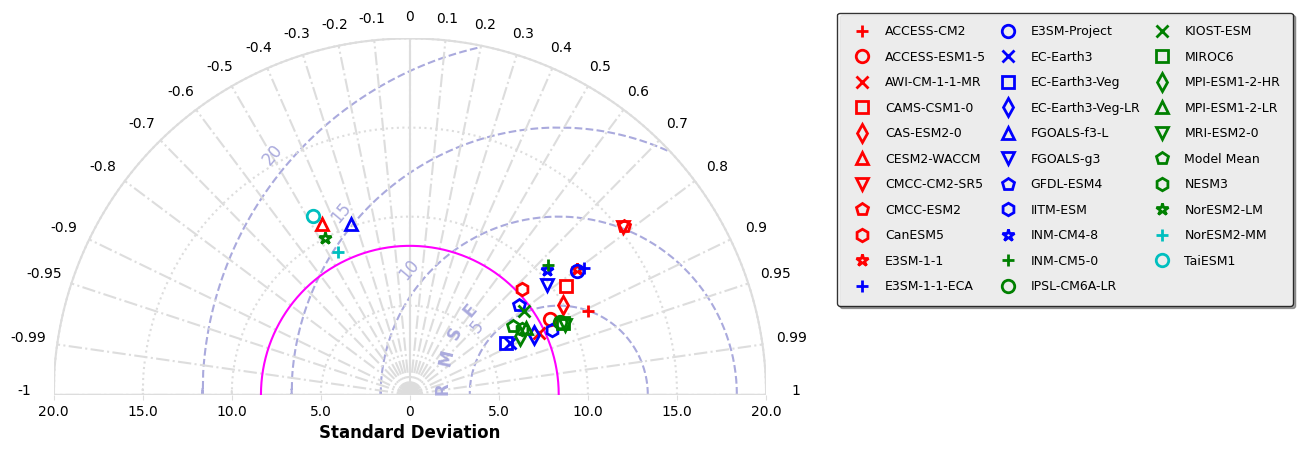

In [98]:
sdev = np.array(Amery_shelf_monthly_corr_data['Standard Deviation'])
crmsd = np.array(Amery_shelf_monthly_corr_data['RMSE'])
ccoef = np.array(Amery_shelf_monthly_corr_data['Spatial Corr'])
label = list(Amery_shelf_monthly_corr_data['Model Names'])


FONT_FAMILY = 'monospace'
FONT_SIZE = 12

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}

MARKERS = {
        "color_edge": "#000000",
    }


mpl.rc('legend', borderpad=1.0) # default is 0.4
# Change vertical space between the legend entries
mpl.rc('legend', labelspacing=1.0) #default is 0.5
# Change the spacing between columns in the legend
mpl.rc('legend', columnspacing=0.75) #default is 2.0
# Draw a shadow behind legend
mpl.rc('legend', shadow=True) #default is False
# Make legend box blue
mpl.rc('legend', edgecolor='k')#default is background patch boundary color
#mpl.rc('legend', fontsize=1)
mpl.rc('legend', loc='best')

fontSize = 16

plt.figure(figsize=(15,15))
sm.taylor_diagram(sdev,crmsd,ccoef,styleOBS = '-',markerLabel = label, markerLabelColor = 'k', 
                          markerLegend = 'on',MarkerDisplayed = 'marker',markerColor = crmsd,
                 markersize =9, alpha = 0.0, colOBS = 'magenta'
                  ,labelRMS = 'RMSE',titleCOR = 'off',
                 colframe='#DDDDDD',tickRMS = [5,10,15,20],
                          colRMS = STYLES_RMS['color'],
                          tickRMSangle = 140,
                          styleRMS = STYLES_RMS['linestyle'],
                          colscor = COLS_COR,
                          colsstd = COLS_STD)

#plt.xlabel("Standard Deviation", color = 'k',fontfamily=FONT_FAMILY,
                          #fontsize=FONT_SIZE+2)
#plt.legend(,fontsize = 20)

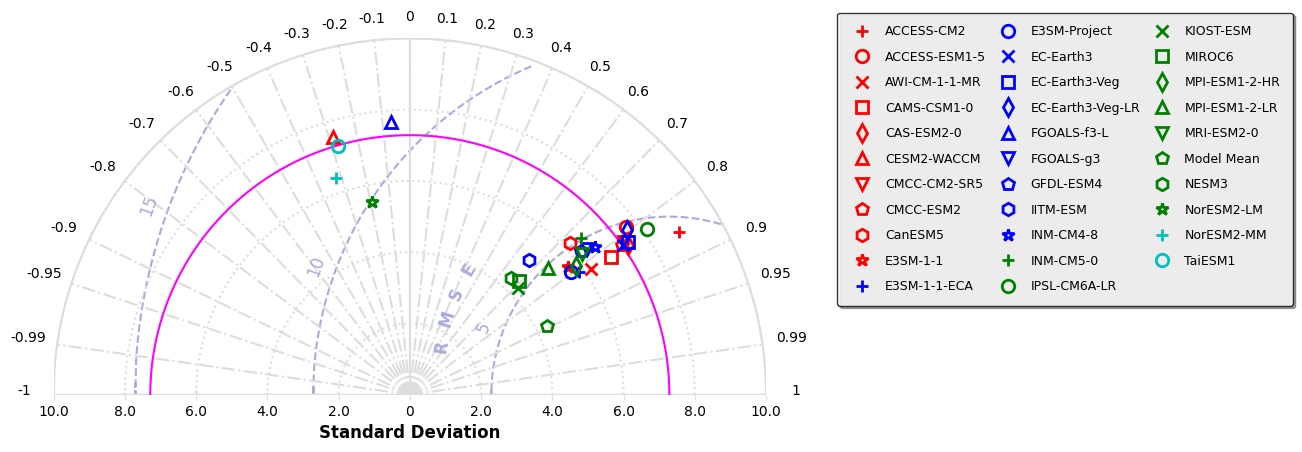

In [99]:
sdev = np.array(LarsenB_shelf_monthly_corr_data['Standard Deviation'])
crmsd = np.array(LarsenB_shelf_monthly_corr_data['RMSE'])
ccoef = np.array(LarsenB_shelf_monthly_corr_data['Spatial Corr'])
label = list(LarsenB_shelf_monthly_corr_data['Model Names'])


FONT_FAMILY = 'monospace'
FONT_SIZE = 12

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}

MARKERS = {
        "color_edge": "#000000",
    }


mpl.rc('legend', borderpad=1.0) # default is 0.4
# Change vertical space between the legend entries
mpl.rc('legend', labelspacing=1.0) #default is 0.5
# Change the spacing between columns in the legend
mpl.rc('legend', columnspacing=0.75) #default is 2.0
# Draw a shadow behind legend
mpl.rc('legend', shadow=True) #default is False
# Make legend box blue
mpl.rc('legend', edgecolor='k')#default is background patch boundary color
#mpl.rc('legend', fontsize=1)
mpl.rc('legend', loc='best')

fontSize = 16

plt.figure(figsize=(15,15))
sm.taylor_diagram(sdev,crmsd,ccoef,styleOBS = '-',markerLabel = label, markerLabelColor = 'k', 
                          markerLegend = 'on',MarkerDisplayed = 'marker',markerColor = crmsd,
                 markersize =9, alpha = 0.0, colOBS = 'magenta'
                  ,labelRMS = 'RMSE',titleCOR = 'off',
                 colframe='#DDDDDD',tickRMS = [5,10,15],
                          colRMS = STYLES_RMS['color'],
                          tickRMSangle = 160,
                          styleRMS = STYLES_RMS['linestyle'],
                          colscor = COLS_COR,
                          colsstd = COLS_STD)

#plt.xlabel("Standard Deviation", color = 'k',fontfamily=FONT_FAMILY,
                          #fontsize=FONT_SIZE+2)
#plt.legend(,fontsize = 20)

In [73]:
monthly_shelf_correlation['LarsenB']


,Model Names,Pearson Corr,Standard Deviation,RMSE,Centered RMSE
20,ACCESS-CM2,0.856274,8.844717,5.223618,4.577563
18,ACCESS-ESM1-5,0.789764,7.674061,5.063414,4.864052
9,AWI-CM-1-1-MR,0.822627,6.178538,4.153253,4.146466
4,CAMS-CSM1-0,0.826317,6.855671,5.765560,4.187378
1,CAS-ESM2-0,0.824601,7.423633,6.096941,4.357939
28,CESM2-WACCM,-0.285912,7.540762,11.913301,11.889231
11,CMCC-CM2-SR5,0.814888,7.396592,4.848813,4.467944
12,CMCC-ESM2,0.818222,7.300007,4.766805,4.397188
26,CanESM5,0.727365,6.202513,5.456569,5.080542
0,E3SM-1-1,0.777772,5.709861,7.010090,4.579388


In [49]:
keys = total_shelf_weights.keys()

total_shelf_applied_weights = grouping_analysis_selection_std(monthly_shelf_correlation,total_shelf_weights,keys)
print(total_shelf_applied_weights['Abbot'].keys())

total_shelf_monthly_corr = np.zeros(len(total_shelf_applied_weights['Ross East']))
total_shelf_std = np.zeros(len(total_shelf_applied_weights['Ross East']))
total_shelf_RMSE = np.zeros(len(total_shelf_applied_weights['Ross East']))
total_shelf_CRMSE = np.zeros(len(total_shelf_applied_weights['Ross East']))

for key in total_shelf_applied_weights: 
    total_shelf_monthly_corr += total_shelf_applied_weights[key]['Pearson Corr']
    total_shelf_std += total_shelf_applied_weights[key]['Standard Deviation']
    total_shelf_RMSE += total_shelf_applied_weights[key]['RMSE']
    total_shelf_CRMSE += total_shelf_applied_weights[key]['Centered RMSE']

model_names = total_shelf_applied_weights['Ross East']['Model Names']

total_shelf_monthly_corr_data = pd.DataFrame(list(zip(model_names,total_shelf_monthly_corr,total_shelf_std,total_shelf_RMSE,total_shelf_CRMSE)),columns=['Model Names','Pearson Corr','STD','RMSE','CRMSE'])
total_shelf_monthly_corr_data

Index(['Model Names', 'Pearson Corr', 'Standard Deviation', 'RMSE',
       'Centered RMSE'],
      dtype='object')


,Model Names,Pearson Corr,STD,RMSE,CRMSE
0,ACCESS-CM2,0.913948,13.204065,6.243954,5.744561
1,ACCESS-ESM1-5,0.898172,10.007481,4.852315,4.366135
2,AWI-CM-1-1-MR,0.884178,8.876126,4.690405,4.545463
3,CAMS-CSM1-0,0.781241,12.438409,9.352724,7.806429
4,CAS-ESM2-0,0.795691,12.478064,9.225971,7.608378
5,CESM2-WACCM,-0.415988,11.403629,17.946021,17.872336
6,CMCC-CM2-SR5,0.786596,13.964356,8.874938,8.689502
7,CMCC-ESM2,0.781345,13.953386,8.947860,8.772890
8,CanESM5,0.740109,11.145494,8.028061,7.646112
9,E3SM-1-1,0.806270,11.466971,7.719232,6.779204


In [58]:
keys = list(('Ross East','Ross West'))
ross_applied_weights_monthly = grouping_analysis_selection_spatial_corr(monthly_shelf_correlation,weights_Ross,keys)
ross_monthly_corr = ross_applied_weights_monthly['Ross East']['Pearson Corr'] + ross_applied_weights_monthly['Ross West']['Pearson Corr']

ross_model_names = ross_applied_weights_monthly['Ross East']['Model Names']

ross_monthly_corr = pd.DataFrame(list(zip(ross_model_names,ross_monthly_corr)),columns=['Model Names','Pearson Corr'])
ross_monthly_corr

,Model Names,Pearson Corr
0,ACCESS-CM2,0.915553
1,ACCESS-ESM1-5,0.898998
2,AWI-CM-1-1-MR,0.872100
3,CAMS-CSM1-0,0.755268
4,CAS-ESM2-0,0.755844
5,CESM2-WACCM,-0.413232
6,CMCC-CM2-SR5,0.779003
7,CMCC-ESM2,0.773575
8,CanESM5,0.742694
9,E3SM-1-1,0.814378


In [59]:
keys = list(('Ronne','Filchner'))

ronne_applied_weights_monthly = grouping_analysis_selection_spatial_corr(monthly_shelf_correlation,weights_Ronne_Filchner,keys)
ronne_monthly_corr = ronne_applied_weights_monthly['Ronne']['Pearson Corr'] + ronne_applied_weights_monthly['Filchner']['Pearson Corr']

ronne_model_names = ronne_applied_weights_monthly['Ronne']['Model Names']

ronne_monthly_corr = pd.DataFrame(list(zip(ronne_model_names,ronne_monthly_corr)),columns=['Model Names','Pearson Corr'])
ronne_monthly_corr

,Model Names,Pearson Corr
0,ACCESS-CM2,0.938497
1,ACCESS-ESM1-5,0.926955
2,AWI-CM-1-1-MR,0.918868
3,CAMS-CSM1-0,0.810367
4,CAS-ESM2-0,0.826531
5,CESM2-WACCM,-0.410884
6,CMCC-CM2-SR5,0.817791
7,CMCC-ESM2,0.810897
8,CanESM5,0.756301
9,E3SM-1-1,0.818060


In [60]:
keys = list(('LarsenB','LarsenC','LarsenD'))

larsen_applied_weights_monthly = grouping_analysis_selection_spatial_corr(monthly_shelf_correlation,weights_Larsen,keys)
larsen_monthly_corr = larsen_applied_weights_monthly['LarsenB']['Pearson Corr'] + larsen_applied_weights_monthly['LarsenC']['Pearson Corr']+larsen_applied_weights_monthly['LarsenD']['Pearson Corr']

larsen_model_names = larsen_applied_weights_monthly['LarsenB']['Model Names']

larsen_monthly_corr = pd.DataFrame(list(zip(larsen_model_names,larsen_monthly_corr)),columns=['Model Names','Pearson Corr'])
larsen_monthly_corr

,Model Names,Pearson Corr
0,ACCESS-CM2,0.907990
1,ACCESS-ESM1-5,0.853051
2,AWI-CM-1-1-MR,0.882825
3,CAMS-CSM1-0,0.869811
4,CAS-ESM2-0,0.873340
5,CESM2-WACCM,-0.352565
6,CMCC-CM2-SR5,0.827545
7,CMCC-ESM2,0.825214
8,CanESM5,0.712666
9,E3SM-1-1,0.810727


In [61]:
keys = list(('Dotson','Crosson','Thwaites','pine island'))

ASE_applied_weights_monthly = grouping_analysis_selection_spatial_corr(monthly_shelf_correlation,weights_ASE,keys)
ASE_monthly_corr = ASE_applied_weights_monthly['Dotson']['Pearson Corr'] + ASE_applied_weights_monthly['Crosson']['Pearson Corr']+ASE_applied_weights_monthly['Thwaites']['Pearson Corr']+ASE_applied_weights_monthly['pine island']['Pearson Corr']

ASE_model_names = ASE_applied_weights_monthly['Dotson']['Model Names']

ASE_monthly_corr = pd.DataFrame(list(zip(ASE_model_names,ASE_monthly_corr)),columns=['Model Names','Pearson Corr'])
ASE_monthly_corr

,Model Names,Pearson Corr
0,ACCESS-CM2,0.842892
1,ACCESS-ESM1-5,0.799262
2,AWI-CM-1-1-MR,0.792489
3,CAMS-CSM1-0,0.717957
4,CAS-ESM2-0,0.742450
5,CESM2-WACCM,-0.387565
6,CMCC-CM2-SR5,0.733299
7,CMCC-ESM2,0.728885
8,CanESM5,0.709281
9,E3SM-1-1,0.757855


In [50]:
total_shelf_spatial_correlation_data_monthly = total_shelf_spatial_correlation_data_monthly.rename(columns={"Model Names": "Model Names", "Pearson Corr": "Spatial Corr"})
extracted_col = total_shelf_spatial_correlation_data_monthly['Spatial Corr']
print(extracted_col)

0     0.904745
1     0.887820
2     0.873694
3     0.774346
4     0.789094
5    -0.412090
6     0.778567
7     0.773435
8     0.732878
9     0.798369
10    0.805421
11    0.799777
12    0.859685
13    0.855921
14    0.848325
15    1.000000
16   -0.299418
17    0.787995
18    0.762083
19    0.890481
20    0.719148
21    0.728905
22    0.889667
23    0.775367
24    0.886328
25    0.864278
26    0.840048
27    0.896854
28    0.845810
29    0.854586
30   -0.416418
31   -0.426515
32   -0.439186
Name: Spatial Corr, dtype: float64


In [51]:
total_shelf_monthly_corr_data = total_shelf_monthly_corr_data.join(extracted_col)
print(total_shelf_monthly_corr_data)

         Model Names  Pearson Corr        STD       RMSE      CRMSE  \
0         ACCESS-CM2      0.913948  13.204065   6.243954   5.744561   
1      ACCESS-ESM1-5      0.898172  10.007481   4.852315   4.366135   
2      AWI-CM-1-1-MR      0.884178   8.876126   4.690405   4.545463   
3        CAMS-CSM1-0      0.781241  12.438409   9.352724   7.806429   
4         CAS-ESM2-0      0.795691  12.478064   9.225971   7.608378   
5        CESM2-WACCM     -0.415988  11.403629  17.946021  17.872336   
6       CMCC-CM2-SR5      0.786596  13.964356   8.874938   8.689502   
7          CMCC-ESM2      0.781345  13.953386   8.947860   8.772890   
8            CanESM5      0.740109  11.145494   8.028061   7.646112   
9           E3SM-1-1      0.806270  11.466971   7.719232   6.779204   
10      E3SM-1-1-ECA      0.813536  11.569378   7.605988   6.706096   
11      E3SM-Project      0.807998  11.583225   7.711903   6.817283   
12         EC-Earth3      0.874237   8.131466   6.682098   4.765805   
13    

In [88]:
total_shelf_monthly_corr_data.to_csv('total_shelf_corr_data.csv')

In [74]:
yearly_bias_all_shelves_alpabet = yearly_bias_all_shelves_alpabet.rename(columns={"Weighted Mean Bias": "Annual Mean Bias"})
print(yearly_bias_all_shelves_alpabet)
annual_mean_all_shelves = yearly_bias_all_shelves_alpabet['Annual Mean Bias']
#total_shelf_monthly_corr_data = total_shelf_monthly_corr_data.join(annual_mean_all_shelves)
print(total_shelf_monthly_corr_data)

         Model Names  Annual Mean Bias
20        ACCESS-CM2         -1.892284
18     ACCESS-ESM1-5         -1.842020
9      AWI-CM-1-1-MR         -0.462881
4        CAMS-CSM1-0          4.864651
1         CAS-ESM2-0          5.018729
28       CESM2-WACCM         -0.431917
11      CMCC-CM2-SR5         -1.341395
12         CMCC-ESM2         -1.290084
26           CanESM5         -1.556835
0           E3SM-1-1          3.341211
29      E3SM-1-1-ECA          3.240504
3       E3SM-Project          3.272577
14         EC-Earth3          4.628867
22     EC-Earth3-Veg          4.613314
23  EC-Earth3-Veg-LR          4.093948
8        FGOALS-f3-L         -0.077072
17         FGOALS-g3         -3.403893
21         GFDL-ESM4         -0.660077
15          IITM-ESM          9.047294
6          INM-CM4-8          0.454394
7          INM-CM5-0         -0.344216
13      IPSL-CM6A-LR         -1.771127
2          KIOST-ESM          6.959229
27            MIROC6          7.959358
5      MPI-ESM1-2-HR     

In [ ]:
seasonal_bias_all_shelves_alpabet = seasonal_bias_all_shelves_alpabet.rename(columns={"Weighted Mean Bias": "Austral Summer (DJF) Mean Bias"})
seasonal_bias_all_shelves_alpabet
seasonal_mean_all_shelves = seasonal_bias_all_shelves_alpabet['Austral Summer (DJF) Mean Bias']
total_shelf_monthly_corr_data = total_shelf_monthly_corr_data.join(seasonal_mean_all_shelves)
print(total_shelf_monthly_corr_data)

In [76]:
total_shelf_monthly_corr_data.to_csv('total_shelf_corr_data.csv')

In [52]:
total_shelf_monthly_corr_data['new'] = range(1,len(total_shelf_monthly_corr_data)+1)
total_shelf_monthly_corr_data.loc[total_shelf_monthly_corr_data.index==15, 'new'] = 0
total_shelf_monthly_corr_data = total_shelf_monthly_corr_data.sort_values("new").drop('new', axis=1)

In [53]:
print(total_shelf_monthly_corr_data)

         Model Names  Pearson Corr        STD       RMSE      CRMSE  \
15              ERA5      1.000000   9.814405   0.000000   0.000000   
0         ACCESS-CM2      0.913948  13.204065   6.243954   5.744561   
1      ACCESS-ESM1-5      0.898172  10.007481   4.852315   4.366135   
2      AWI-CM-1-1-MR      0.884178   8.876126   4.690405   4.545463   
3        CAMS-CSM1-0      0.781241  12.438409   9.352724   7.806429   
4         CAS-ESM2-0      0.795691  12.478064   9.225971   7.608378   
5        CESM2-WACCM     -0.415988  11.403629  17.946021  17.872336   
6       CMCC-CM2-SR5      0.786596  13.964356   8.874938   8.689502   
7          CMCC-ESM2      0.781345  13.953386   8.947860   8.772890   
8            CanESM5      0.740109  11.145494   8.028061   7.646112   
9           E3SM-1-1      0.806270  11.466971   7.719232   6.779204   
10      E3SM-1-1-ECA      0.813536  11.569378   7.605988   6.706096   
11      E3SM-Project      0.807998  11.583225   7.711903   6.817283   
12    

In [54]:
import skill_metrics as sm
print(sm.__path__)
import matplotlib as mpl

['/home/mafields/.conda/envs/cartopy-dev/lib/python3.10/site-packages/skill_metrics']


10.018301529758345
4.468316029096094
0.8863282888691463
MIROC6


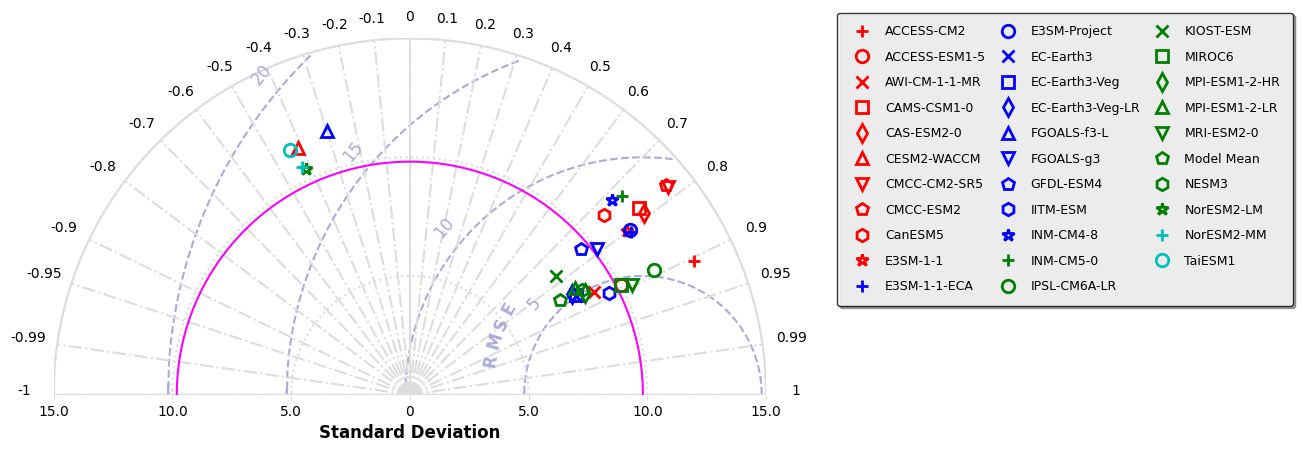

In [80]:
sdev = np.array(total_shelf_monthly_corr_data['STD'])
print(sdev[24])
crmsd = np.array(total_shelf_monthly_corr_data['CRMSE'])
print(crmsd[24])
ccoef = np.array(total_shelf_monthly_corr_data['Spatial Corr'])
print(ccoef[24])
label = list(total_shelf_monthly_corr_data['Model Names'])
print(label[24])


FONT_FAMILY = 'monospace'
FONT_SIZE = 12

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}

MARKERS = {
        "color_edge": "#000000",
    }


mpl.rc('legend', borderpad=1.0) # default is 0.4
# Change vertical space between the legend entries
mpl.rc('legend', labelspacing=1.0) #default is 0.5
# Change the spacing between columns in the legend
mpl.rc('legend', columnspacing=0.75) #default is 2.0
# Draw a shadow behind legend
mpl.rc('legend', shadow=True) #default is False
# Make legend box blue
mpl.rc('legend', edgecolor='k')#default is background patch boundary color
#mpl.rc('legend', fontsize=1)
mpl.rc('legend', loc='best')

fontSize = 16

plt.figure(figsize=(15,12))
sm.taylor_diagram(sdev,crmsd,ccoef,styleOBS = '-',markerLabel = label, markerLabelColor = 'k', 
                          markerLegend = 'on',MarkerDisplayed = 'marker',markerColor = crmsd,
                 markersize =9, alpha = 0.0, colOBS = 'magenta',labelRMS = 'RMSE',titleCOR = 'off',
                 colframe='#DDDDDD',tickRMS = [5,10,15,20],
                          colRMS = STYLES_RMS['color'],
                          tickRMSangle = 140,
                          styleRMS = STYLES_RMS['linestyle'],
                          colscor = COLS_COR,
                          colsstd = COLS_STD)

#plt.xlabel("Standard Deviation", color = 'k',fontfamily=FONT_FAMILY,
                          #fontsize=FONT_SIZE+2)
#plt.legend(,fontsize = 20)

In [66]:
test = total_shelf_monthly_corr_data.iloc[0:2,:]
test_std = np.array(test['STD'])
test_CRMSE = np.array(test['CRMSE'])
test_corr = np.array(test['Spatial Corr'])
test_label = list(test['Model Names'])

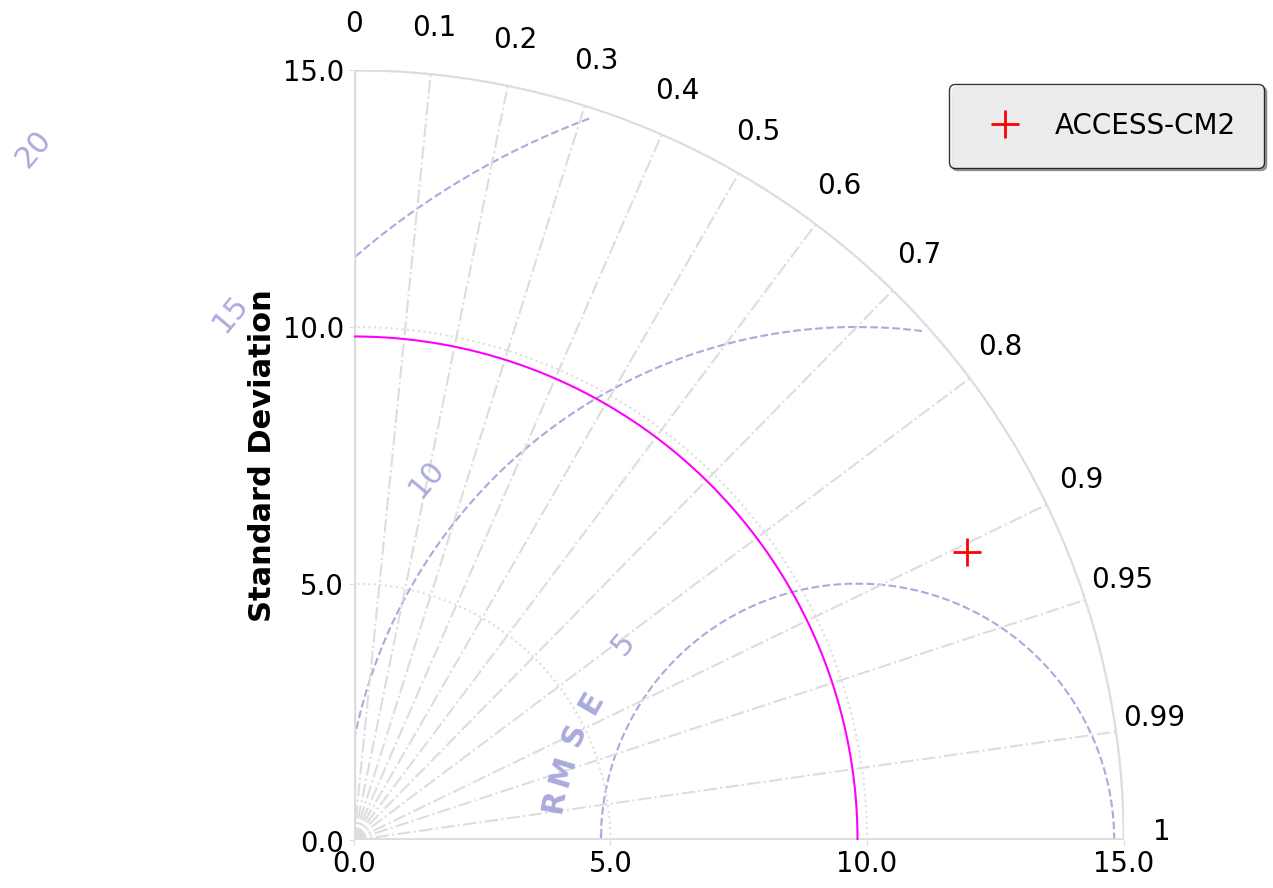

In [82]:
plt.figure(figsize=(12,10))

FONT_FAMILY = 'monospace'
FONT_SIZE = 20

mpl.rc('font', size=20)
sm.taylor_diagram(test_std,test_CRMSE,test_corr,styleOBS = '-',markerLabel = test_label, markerLabelColor = 'k', 
                          markerLegend = 'on',MarkerDisplayed = 'marker',markerColor = 'r',
                 markersize =20, alpha = 0.0, colOBS = 'magenta',labelRMS = 'RMSE',titleCOR = 'off',
                 colframe='#DDDDDD',tickRMS = [5,10,15,20],
                          colRMS = STYLES_RMS['color'],
                          tickRMSangle = 140,
                          styleRMS = STYLES_RMS['linestyle'],
                          colscor = COLS_COR,
                          colsstd = COLS_STD)

In [59]:
RMS = np.sqrt(sdev**2 + sdev[0]**2 - 2*sdev*sdev[0]*ccoef)
print(RMS)

[1.68587394e-07 6.01481720e+00 4.69822213e+00 4.78397645e+00
 7.87268194e+00 7.66499781e+00 1.78495750e+01 8.82709563e+00
 8.89858053e+00 7.75956614e+00 6.93648196e+00 6.87514286e+00
 6.97512865e+00 5.02275480e+00 5.08082125e+00 5.20411225e+00
 1.73415176e+01 6.45335890e+00 6.66074439e+00 4.51878735e+00
 8.32125549e+00 8.42466981e+00 5.28742238e+00 6.20701952e+00
 4.73231582e+00 4.93699505e+00 5.32451661e+00 4.63252176e+00
 5.29796502e+00 5.09796743e+00 1.70673693e+01 1.72641306e+01
 1.80771574e+01]


In [87]:
crmsd - RMS

array([-1.68587394e-07, -2.70256367e-01, -3.32087059e-01, -2.38513689e-01,
       -6.62528403e-02, -5.66199902e-02,  2.27614738e-02, -1.37593318e-01,
       -1.25690154e-01, -1.13454240e-01, -1.57278381e-01, -1.69046933e-01,
       -1.57846141e-01, -2.56949337e-01, -2.50265548e-01, -2.42468877e-01,
        5.03022381e-02, -1.25246817e-01, -1.23055170e-01, -3.04270255e-01,
       -1.48854186e-01, -1.61134255e-01, -2.97210519e-01, -1.51168317e-01,
       -2.63999793e-01, -2.61277517e-01, -2.07025979e-01, -2.85205934e-01,
       -9.08437753e-02, -2.31719351e-01,  2.60301726e-02,  2.62461244e-02,
        5.12646140e-02])

In [86]:
ccoef

array([ 1.        ,  0.90474488,  0.8878203 ,  0.87369372,  0.77434586,
        0.789094  , -0.41208977,  0.77856729,  0.77343481,  0.73287779,
        0.79836856,  0.80542054,  0.79977698,  0.85968522,  0.8559211 ,
        0.84832538, -0.29941809,  0.78799484,  0.76208273,  0.89048114,
        0.71914804,  0.72890479,  0.88966718,  0.77536735,  0.88632829,
        0.86427799,  0.8400485 ,  0.89685448,  0.8458098 ,  0.85458621,
       -0.41641795, -0.42651526, -0.43918646])

In [84]:
crmsd

array([ 0.        ,  5.74456083,  4.36613507,  4.54546277,  7.80642909,
        7.60837782, 17.87233644,  8.68950231,  8.77289038,  7.6461119 ,
        6.77920358,  6.70609592,  6.81728251,  4.76580546,  4.8305557 ,
        4.96164337, 17.39181986,  6.32811208,  6.53768923,  4.2145171 ,
        8.17240131,  8.26353556,  4.99021186,  6.0558512 ,  4.46831603,
        4.67571753,  5.11749063,  4.34731582,  5.20712125,  4.86624808,
       17.09339948, 17.29037676, 18.12842206])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

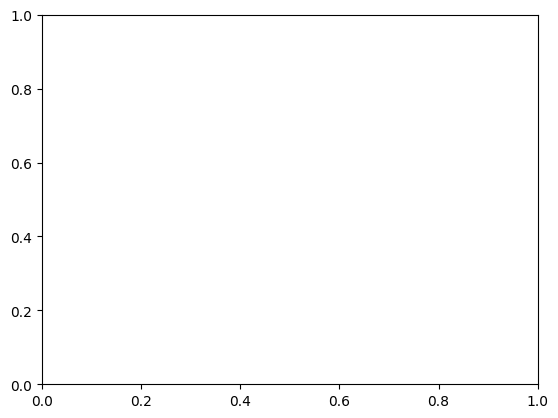

In [68]:
test_sdev = np.array(sdev[0],sdev[24])
test_crmsd = np.array(crmsd[0],crmsd[24])
test_ccoef = np.array(ccoef[0],ccoef[24])
#label_test = list((label[0],label[24]))

sm.taylor_diagram(test_sdev,test_crmsd,test_ccoef,styleOBS = '-', markerLabelColor = 'k', 
                          markerLegend = 'on',MarkerDisplayed = 'marker',markerColor = crmsd,
                 markersize =9, alpha = 0.0, colOBS = 'magenta',labelRMS = 'RMSE',titleCOR = 'off',
                 colframe='#DDDDDD',tickRMS = [5,10,15,20],
                          colRMS = STYLES_RMS['color'],
                          tickRMSangle = 140,
                          styleRMS = STYLES_RMS['linestyle'],
                          colscor = COLS_COR,
                          colsstd = COLS_STD)

In [ ]:
 {
                              'face': 'r',
                              "edge": MARKERS["color_edge"]
                              }

In [ ]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import skill_metrics as sm
from sys import version_info

#if __name__ == '__main__':

    # Define optional arguments for script
    #arg_parser = argparse.ArgumentParser()
    #arg_parser.add_argument('-noshow', dest='no_show', action='store_true',
                           # help="No figure is shown if this flag is present.")
    #arg_parser.add_argument('-nosave', dest='no_save', action='store_true',
                            #help="No figure is saved if this flag is present.")
    #args = arg_parser.parse_args()
    #del arg_parser
    
    # Close any previously open graphics windows
   # plt.close('all')
    #
    # Read data from CSV files
    #data_files = ['pred1.csv', 'pred2.csv', 'pred3.csv', 'ref.csv']
    #data = load_data(data_files)

    # Calculate statistics for Taylor diagram
    # The first array element (e.g. taylor_stats1[0]) corresponds to the 
    # reference series while the second and subsequent elements
    # (e.g. taylor_stats1[1:]) are those for the predicted series.
    #taylor_stats1 = sm.taylor_statistics(data['pred1'],data['ref'],'data')
    #taylor_stats2 = sm.taylor_statistics(data['pred2'],data['ref'],'data')
    #taylor_stats3 = sm.taylor_statistics(data['pred3'],data['ref'],'data')
    
    # Store statistics in arrays
    #sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                     #taylor_stats2['sdev'][1], taylor_stats3['sdev'][1]])
    #crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                      #taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1]])
    #ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                      #taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1]])

    # Specify labels for points in a cell array (M1 for model prediction 1,
    # etc.). Note that a label needs to be specified for the reference even
    # though it is not used.
    label = np.array(total_shelf_monthly_corr_data['Model Names'])
    
    '''
    Produce the Taylor diagram
    Display the data points for correlations that vary from -1 to 1 (2
    panels). Label the points and change the axis options for SDEV, CRMSD,
    and CCOEF. Increase the upper limit for the SDEV axis and rotate the
    CRMSD contour labels (counter-clockwise from x-axis). Exchange color and
    line style choices for SDEV, CRMSD, and CCOEFF variables to show effect. 
    Increase the line width of all lines.
    For an exhaustive list of options to customize your diagram, 
    please call the function at a Python command line:
    >> taylor_diagram
    '''
    sm.taylor_diagram(sdev,crmsd,ccoef,
                      numberPanels = 2,
                      markerLabel = label, markerLabelColor = 'r',
                      tickRMS = range(0,90,10), tickRMSangle = 150.0,
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                      titleRMS = 'off',
                      tickSTD = range(0, 80, 20), axismax = 60.0,
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0)

    # Write plot to file if arguments say so
    None if args.no_save else plt.savefig('taylor7.png')

    # Show plot if arguments say so
    None if args.no_show else plt.show()
    plt.close()

In [ ]:
label = list(total_shelf_monthly_corr_data['Model Names'])

plt.figure(figsize=(15,12))
sm.taylor_diagram(sdev,crmsd,ccoef,
                      numberPanels = 2,
                      markerLabel = label, markerLabelColor = 'r',
                      tickRMS = range(0,90,10), tickRMSangle = 150.0,
                      colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                      titleRMS = 'off',
                      tickSTD = range(0, 20, 5), axismax = 20.0,
                      colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                      colCOR = 'k', styleCOR = '--', widthCOR = 1.0,
                  styleOBS = '-', colOBS = 'b', markerobs = 'o', titleOBS = 'observation')

In [ ]:
sm.taylor_diagram(sdev,crmsd,ccoef)

In [ ]:
8.8/2